In [2]:
import flopy
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from flopy.utils.reference import SpatialReference
from SimPEG import Mesh
import glob
from  pyproj import Proj
from shapely.geometry import Point, Polygon


########## INPUT #############
# it = int(sys.argv[1])-1
# f_varlist = Path(sys.argv[2])
# job_id = sys.argv[3]

it=1
f_varlist = Path('../data/PriorModel/varlist.pkl')
job_id = 'test'
print('inputs:',it,f_varlist,job_id)
########## INPUT #############




if sys.platform.lower()=='linux':
    datadir = Path('/scratch/users/ianpg/SWIlarge/data')
    workdir = Path('/scratch/users/ianpg/SWIlarge/work')
    MPSdir = datadir.joinpath('lith/sgems/MPS')
    lithdir = datadir.joinpath('lith/sgems/')
    GISdir = datadir.joinpath('GIS')
    priordir = datadir.joinpath('PriorModel')
elif sys.platform.lower()=='darwin':
    datadir = Path('../data')
    workdir = Path('../work')
    MPSdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS')
    GISdir = datadir.joinpath('GIS')
    lithdir = datadir.joinpath('lith/sgems/')
    priordir = datadir.joinpath('PriorModel')


nmgwmdir_cal = datadir.joinpath('Calibrated_small') #<-- removed RCH, WEL, GLO, LST from the NAM file to load much faster
figdir = workdir.joinpath('figs')
outputdir = workdir.joinpath('output')



#Local imports and file creation
simpegskytem_path = '../../kang-2019-3D-aem/codes'
if not simpegskytem_path in sys.path:
    sys.path.append(simpegskytem_path)

import simpegskytem
from simpegskytem import ProblemSkyTEM, GlobalAEMSurveyTD, GlobalSkyTEM, get_skytem_survey,Utils

import config



p = Proj("epsg:26910")
xll=595855
yll = 4059438
rotation = -13.5

searchname = outputdir.joinpath('SV','conc{}_*totim14782_*.npy'.format(it)).as_posix()
# searchname = outputdir.joinpath('NM','conc{}_*totim14782.npy'.format(it)).as_posix()
f_conc=glob.glob(searchname)
if len(f_conc)==0:
    print('No SEAWAT concentration grid found with the name {}'.format(searchname))
    sys.exit()
elif len(f_conc)==1:
    print('1 SEAWAT concentration grid found!')
    f_conc = f_conc[0]
elif len(f_conc)>1:
    print('{} SEAWAT concentration grids found, using the latest...'.format(len(f_conc)))
    f_conc.sort(key=os.path.getmtime)
    f_conc = f_conc[-1]



#%% Useful functions

def load_obj(dirname,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

def save_obj(dirname,obj,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)




#RP transforms 
import numpy as np
import matplotlib.pyplot as plt


def TDS_to_sigmaf(TDS,mTDS=1.4200556641030946,bTDS=332.7093594248108):
    '''
    Linear relationship of TDS to fluid resistivity
    input: 
        TDS in g/L
        mTDS,bTDS: fitting params
    output: 
        sigma_f: fluid conductivity in S/m
    '''
    return (mTDS*TDS*1000 + bTDS)/1e4


def WS_sigma(sigma_f, por = 0.4, CEC=1,B0=4.5e-8, m=1.3):
    '''
    Waxman-Smits relationship for a clayey sand 
    input:
        sigma_f: fluid conductivity in S/m
        por: porosity
        CEC: cation exchange capacity (meq/g)
            1:smectite,  .2:Illite,  .02-.09:Kaolinite
        B0: fitting parameter (default value taken from Revil and Glover, 1998)
        m: Archie cementation exponent (0.5-2 for unconsolidated materials)
    returns:
        sigma_b: bulk conductivity in S/m
    '''
    rho_grain = 2650*1000 #g/m^3
    F = por**(-m)
    Qv = rho_grain*((1-por)/por)*CEC
    B = B0*(1-.6*np.exp(-sigma_f/.013))
    sigma_b = 1/F*(sigma_f + B*Qv)
    return sigma_b,B,Qv


def HSU(sigma1,sigma2,chi2):
    '''
    Hashin-Shtrikman upper bound
    input:
        sigma1: conductivity of the less conductive constituent
        sigma2: conductivity of the more conductive constituent
        chi2: volume fraction of the more conductive constituent
    returns:
        HSU
    '''
    return sigma2*(1 - (3*(1-chi2)*(sigma2-sigma1))/(3*sigma2 - chi2*(sigma2-sigma1)))

def RP_twostep(TDS,CF,**kwargs):
    '''
    RP relationship for upscaling
    1) Waxman-Smits relationship to estimate the conductivity of constituents:
        sigma_clay and sigma_sand
    2) Hashin-Shtrikman upper bound to predict global conductivity at the large scale 
    input:
        TDS (mg/L)
        CF: clay fraction at the upscaled volume
        **kwargs: fed to WS_sigma function
    returns:
        upscaled global conductivity weighted by clay fraction (in S/m)
    '''

    #kwargs fed to WS_sigma
    Cw = TDS_to_sigmaf(TDS)
    sigma_sand = WS_sigma(Cw,CEC=0,**kwargs)[0]
    sigma_clay = WS_sigma(Cw,CEC=1,**kwargs)[0]
    return HSU(sigma_sand,sigma_clay,CF)


print('loading seawat models and variables')

nmgwmdir_cal_empty = nmgwmdir_cal.parent.joinpath('nmgwmdir_empty')

m_nm= flopy.modflow.Modflow.load('nm_cali.nam',version='mf2k',verbose=False,check=False,model_ws=nmgwmdir_cal_empty.as_posix())
# m = flopy.modflow.Modflow.load(nmgwmdir_uncal.joinpath('C1-12_copy.nam').as_posix(),version='mf2k',verbose=False,check=False,model_ws=outputdir.joinpath('C1').as_posix())
m_nm.exe_name = config.mf2000exe
if not m_nm.DIS.lenuni==2:
    m_nm.DIS.delr *= .3048
    m_nm.DIS.delc *= .3048
    m_nm.DIS.top *= .3048
    m_nm.DIS.botm *= .3048
m_nm.DIS.lenuni = 2
m_nm.DIS.itmuni=4
m_nm.DIS.rotation=-13.5
# m_nm.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_nm.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_nm.DIS.proj4_str = p.srs
m_nm.modelgrid.set_coord_info(xoff=xll, yoff=yll, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')



model_ws = workdir.joinpath('SV_{}'.format(it))


##Loading
modelname = 'SV'
m= flopy.seawat.Seawat.load(modelname + '.nam',exe_name=config.swexe, model_ws=model_ws.as_posix())
rows = np.load(model_ws.joinpath('rows.npy'))
starttime = np.load(model_ws.joinpath('starttime.npy'))
layer_mapping_ind_full = np.load(GISdir.joinpath('layer_mapping_ind_full.npy'))                                 
layer_mapping_ind = layer_mapping_ind_full[:,rows,:]
# m = flopy.seawat.Seawat(modelname, exe_name=config.swexe, model_ws=model_ws.as_posix(),verbose=verbose)
# thinmsk_in_aqt = np.load(model_ws.joinpath('thinmsk_in_aqt.npy'))
# wellmsk_in_aqt = np.load(model_ws.joinpath('wellmsk_in_aqt.npy'))
topo_grid = np.load(GISdir.joinpath('topo_grid.npy'))
topo_grid_fine = np.loadtxt(GISdir.joinpath('Topography_fine','TopographyMesh_vertices.csv'),skiprows=1,delimiter=',')
conc = np.load(f_conc)

if len(f_varlist.name.split('.'))>1:
    nam = f_varlist.name.split('.')[0]
else:
    nam = f_varlist.name
varlist = load_obj(f_varlist.parent,nam)


m_empty = flopy.modflow.Modflow('m_empty', model_ws=model_ws.joinpath('m_empty').as_posix())
flopy.modflow.ModflowDis(m_empty, m.nlay, m.nrow, m.ncol, nper=m.nper, delr=m.dis.delr,
                               delc=m.dis.delc,
                               laycbd=0, top=m.dis.top,
                               botm=m.dis.botm, perlen=m.dis.perlen, nstp=m.dis.nstp,
                               steady=m.dis.steady,itmuni=m.dis.itmuni,lenuni=m.dis.lenuni,
                               tsmult=m.dis.tsmult)

xll_m,yll_m = m_nm.modelgrid.xvertices[rows[-1]+1,0],m_nm.modelgrid.yvertices[rows[-1]+1,0]





m_empty.DIS.lenuni = 2
m_empty.DIS.itmuni=4
m_empty.DIS.rotation=-13.5
# m_empty.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_empty.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_empty.DIS.proj4_str = p.srs
m_empty.modelgrid.set_coord_info(xoff=xll_m, yoff=yll_m, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')



df_1719 = pd.read_pickle(datadir.joinpath('AEM','processed_df_1719.pkl'))
df = df_1719.loc[df_1719.skytem_type==304,:]


ch1_cols = [c for c in df.columns if c.startswith('DBDT_Ch1')]
ch2_cols = [c for c in df.columns if c.startswith('DBDT_Ch2')]

#Remove soundings with few time gates
thresh = 15
# (df.loc[df.CHANNEL_NO==1,ch1_cols]==9999.).sum(axis=1).hist()
# plt.title('Distribution time gates')
# plt.xlabel('No. invalid time gates')
# plt.ylabel('No. soundings')
# ylims=plt.ylim()
# plt.vlines(thresh,0,ylims[1],label='threshold')
# plt.ylim(ylims)
# plt.legend()

rm_mask = (df.loc[df.CHANNEL_NO==1,ch1_cols]==9999.).sum(axis=1) > thresh 
remove_inds = rm_mask[rm_mask==True].index
df = df.drop(index=np.r_[remove_inds,remove_inds+1])

#Remove soundings with large jumps
ch1X = df.UTMX.values[::2]
ch2X =  df.UTMX.values[1::2]
ch1Y = df.UTMY.values[::2]
ch2Y =  df.UTMY.values[1::2]
diff = np.sqrt( (ch1X - ch2X)**2 + (ch1Y - ch2Y)**2)
large_jump = diff > np.std(diff)
large_jump_ind = df.UTMX[::2][large_jump].index.values
df = df.drop(index=np.r_[large_jump_ind,large_jump_ind+1])




def utmrotate(x,y,x0=595855,y0=4059438,rotation=13.5,local=False):
    rotation = rotation*np.pi/180
    if local:
        orig_x,orig_y = (0,0)
    else:
        orig_x,orig_y = (x0,y0)
        
    x_rot = np.cos(rotation)*(x-x0) - np.sin(rotation)*(y-y0) + orig_x
    y_rot = np.sin(rotation)*(x-x0) + np.cos(rotation)*(y-y0) + orig_y
    return x_rot,y_rot  

#xll,yll for local grid
xmll,ymll = m_empty.modelgrid.xvertices[-1,0],m_empty.modelgrid.yvertices[-1,0]
xmll_rot,ymll_rot = utmrotate(xmll,ymll,x0=xll,y0=yll)

def global_to_local(x_glob,y_glob,rotx0=xll,roty0=yll,x0_local=xmll_rot,y0_local=ymll_rot):
    x_temp,y_temp = utmrotate(x_glob,y_glob,local=False,x0=rotx0,y0=roty0)
    x_temp -= x0_local
    y_temp -= y0_local
    return np.stack((x_temp,y_temp),axis=1)



#Remove values outside of the AEM_box


iskip = 6
coords = [(m_empty.modelgrid.xvertices[0,0], m_empty.modelgrid.yvertices[0,0]),
          (m_empty.modelgrid.xvertices[-1,0], m_empty.modelgrid.yvertices[-1,0]),
          (m_empty.modelgrid.xvertices[-1,-1], m_empty.modelgrid.yvertices[-1,-1]),
          (m_empty.modelgrid.xvertices[0,-1], m_empty.modelgrid.yvertices[0,-1])
         ]
model_poly = Polygon(coords)
msk_AEM = np.zeros(len(df),dtype=np.bool)
for i,(x,y) in enumerate(zip(df.UTMX.values,df.UTMY.values)):
    msk_AEM[i]=Point(x,y).within(model_poly)
msk = np.logical_and(df.CHANNEL_NO==1, msk_AEM)
data_hm_all = df.loc[msk[msk].index+1,ch2_cols][::iskip]
data_lm_all = df.loc[msk[msk].index,ch1_cols][::iskip]






## Get the AEM data within boundary
iskip = 6
coords = [(m_empty.modelgrid.xvertices[0,0], m_empty.modelgrid.yvertices[0,0]),
          (m_empty.modelgrid.xvertices[-1,0], m_empty.modelgrid.yvertices[-1,0]),
          (m_empty.modelgrid.xvertices[-1,-1], m_empty.modelgrid.yvertices[-1,-1]),
          (m_empty.modelgrid.xvertices[0,-1], m_empty.modelgrid.yvertices[0,-1])
         ]
model_poly = Polygon(coords)
msk_AEM = np.zeros(len(df),dtype=np.bool)
for i,(x,y) in enumerate(zip(df.UTMX.values,df.UTMY.values)):
    msk_AEM[i]=Point(x,y).within(model_poly)
msk = np.logical_and(df.CHANNEL_NO==1, msk_AEM)
data_hm_all = df.loc[msk[msk].index+1,ch2_cols][::iskip]
data_lm_all = df.loc[msk[msk].index,ch1_cols][::iskip]





#TAKE THE LOCATION OF CHANNEL 1 FOR EACH SOUNDING
# msk = np.logical_and(df.CHANNEL_NO==1, df.LINE_NO == line)
x_m_rot,y_m_rot = utmrotate(m_empty.modelgrid.xvertices.flatten(),m_empty.modelgrid.yvertices.flatten(),local=False)

xy_global = df.loc[msk,['UTMX', 'UTMY']].values[::iskip]
xy = global_to_local(xy_global[:,0],xy_global[:,1])

Line = df.loc[msk,['LINE_NO']].values[::iskip]
dem = df.loc[msk,'ELEVATION'].values[::iskip]
height = df.loc[msk,'INVALT'].values[::iskip]
# height = df.loc[msk,'TX_ALTITUDE'].values[:]
system = df.loc[msk,'skytem_type'].values[::iskip]
msk_312 = system==312
rx_locations = np.c_[xy[:,:], height+dem+2.]
src_locations = np.c_[xy[:,:], height+dem]
topo = np.c_[xy[:,:], dem]
n_sounding= xy.shape[0]

dx,dy,dz = (m_empty.dis.delr.array[0],
            m_empty.dis.delc.array[0],
            m_empty.dis.botm[-1] - m_empty.dis.botm[-2])


print ( 'msk',msk.shape,'\n'
'xy',xy.shape,'\n'
'Line',Line.shape,'\n'
'dem',dem.shape,'\n'
'height',height.shape,'\n'
'system',system.shape,'\n'
'rx_locations',rx_locations.shape,'\n'
'src_locations',src_locations.shape,'\n'
'topo',topo.shape,'\n')
#nodenumber in grid corresponding to AEM locations
# nodenumber_AEM = g.intersect(list(xy_global),'point',0).nodenumber





print('Making the mesh...')

nlay,nrow,ncol = (m_empty.nlay,
                  m_empty.nrow,
                  m_empty.ncol)
dx,dy,dz = (m_empty.dis.delr.array[0],
            m_empty.dis.delc.array[0],
             (m_empty.dis.botm[-2]-m_empty.dis.botm[-1]).mean())
Lx,Ly,Lz = (dx*ncol,
            dy*nrow,
            dz*nlay)


n_pad_ocean = 0
n_pad_inland = 100
n_pad_row = 10

hx = np.ones(ncol+n_pad_ocean+n_pad_inland) * dx
hy = np.ones(m_nm.nrow) * dy

hz = np.ones(71)*dz

# x0 = (-n_pad_inland*dx +x_m_rot.min(),-n_pad_row*dy + y_m_rot.min(),-386.21)
x0 = (-n_pad_ocean*dx,-n_pad_row*dy,-386.21)

mesh_large = Mesh.TensorMesh([hx, hy, hz],x0=x0)


hx = np.ones(ncol+n_pad_ocean+n_pad_inland) * dx
hy = np.ones(nrow + 2*n_pad_row) * dy
hz = np.ones(71)*dz

mesh = Mesh.TensorMesh([hx, hy, hz],x0=x0)

def find_ocean(m,layer_mapping_ind,ocean_elev=0):
    ocean_line = []

    for lay in range(m.dis.nlay):
        for row in range(m.dis.nrow):
            thislay = (lay,row,np.where(layer_mapping_ind[lay,row,:]!=0)[0][0])
            ocean_line.append(thislay)
            if lay==m.dis.nlay-1:
                pass
            else:
                nextlay = (lay+1,row,np.where(layer_mapping_ind[lay+1,row,:]!=0)[0][0])
                for col in np.arange(thislay[2],nextlay[2],-1):
                    ocean_line.append((lay,row,col))
    ocean_line = np.array(ocean_line).T


    ocean_grid = np.zeros((m.nlay,m.nrow,m.ncol),dtype=np.bool)
    ocean_grid[tuple(ocean_line)]=True
    ocean_grid[m.modelgrid.zvertices[1:,:,:]>ocean_elev]=False
    return ocean_line,ocean_grid

ocean_line,ocean_grid = find_ocean(m_nm,layer_mapping_ind_full)




from SimPEG.Utils import plot2Ddata, surface2ind_topo
x_nm,y_nm = utmrotate(m_nm.modelgrid.xcellcenters.flatten(),
                              m_nm.modelgrid.ycellcenters.flatten(),
                             x0=xll,y0=yll)
x_nm -= xmll_rot
y_nm-= ymll_rot

sealevel_X,sealevel_Y = np.meshgrid(mesh.vectorCCx,mesh.vectorCCy)
sealevel_xyz = np.stack((sealevel_X.flatten(),sealevel_Y.flatten(),np.zeros(sealevel_X.size)),axis=1)
topo_xyz =np.stack((x_nm.flatten(),
                    y_nm.flatten(),
                    topo_grid.flatten()),axis=1)

actv = surface2ind_topo(mesh,topo_xyz) #True if below ground surface 
isabove_sealevel = ~surface2ind_topo(mesh,sealevel_xyz) #True if below sea level



print('Applying RP transform...')

RP_model = varlist['RP_model'][it]
m_ws = varlist['m'][it] #done
CF_cp = varlist['CF_cp'][it] #done
CF_cr = varlist['CF_cr'][it] #done
por = m.btn.prsity.array
lith_180 = np.load(lithdir.joinpath('snesim','mps180_{}.npy'.format(it))).astype(np.float)
lith_400 = np.load(lithdir.joinpath('sisim','sisim400_{}.npy'.format(it))).astype(np.float)


hk_m = m.lpf.hk.array
cf = np.zeros_like(hk_m,dtype=np.float) #0=Clay, 1=Sand
cf[np.where(hk_m > 1e-1)]=CF_cp
cf[np.where(hk_m <= 1e-1)]=CF_cr
conc[conc > 100.] = np.nan



# cf = np.zeros_like(layer_mapping_ind_full,dtype=np.float) #0=Clay, 1=Sand
# cf[np.where(layer_mapping_ind_full==0)] = 1
# cf[np.where(layer_mapping_ind_full==1)] = 1
# cf[np.where(layer_mapping_ind_full==2)] = 0
# cf[np.where(layer_mapping_ind_full==3)] = lith_180[np.where(layer_mapping_ind_full==3)] 
# cf[np.where(layer_mapping_ind_full==4)] = 0
# cf[np.where(layer_mapping_ind_full==5)] = lith_400[np.where(layer_mapping_ind_full==5)] 
# cf[np.where(layer_mapping_ind_full>5)] = 1
# cf[np.where(cf==0)] = CF_cr
# cf[np.where(cf==1)] = CF_cp
# cf = cf[:,rows,:]

if RP_model==0:
    #  WS -- HS+ transform
    sigma_bulk = RP_twostep(TDS=conc,CF=cf,por=por,m=m_ws)    
elif RP_model==1:
    #ML transform
    import lightgbm 
    gbm = lightgbm.Booster(model_file=datadir.joinpath('RockPhysics','gbm_production_model.mdl').as_posix())

    
    z_m = m_empty.modelgrid.zcellcenters
    top_elev = m_empty.modelgrid.zvertices[0,:,:]


    dept = (top_elev - z_m)/.3048
    dept_bin = (np.round(dept/10,0)*10).astype(np.int)

    aq_groupnum = np.zeros_like(layer_mapping_ind)
    aq_groupnum[np.where(np.isin(layer_mapping_ind,(1,2)))] = 1
    aq_groupnum[np.where(np.isin(layer_mapping_ind,(3,4)))] = 2
    aq_groupnum[np.where(layer_mapping_ind>=5)] = 3

    X = np.tile(m_empty.modelgrid.xcellcenters,(m_empty.nlay,1,1))
    Y = np.tile(m_empty.modelgrid.ycellcenters,(m_empty.nlay,1,1))
    TDS = conc*1000
    
    data = np.stack((TDS.flatten(),
                cf.flatten(),
                aq_groupnum.flatten(),
                dept_bin.flatten(),
                X.flatten(),
                Y.flatten()),axis=1)
    
    sigma_bulk = np.power(10,gbm.predict(data))
    sigma_bulk = sigma_bulk.reshape((m_empty.nlay,m_empty.nrow,m_empty.ncol))
    

print('merging grids...')

aem_rho_tmp = np.load(datadir.joinpath('AEM','resistivity','AEM_Modflowsize.npy'),allow_pickle=True)
aem_msk = aem_rho_tmp =='OUT'
aem_rho = np.zeros_like(aem_rho_tmp,dtype='float')
aem_rho[~aem_msk] = aem_rho_tmp[~aem_msk]
aem_rho[aem_msk] = np.nan
aem_rho=aem_rho.reshape((52,m_nm.nrow,m_nm.ncol))[::-1,::-1,:]
aem_rho = np.power(10,aem_rho)

rho_background=10.
ind_bot_lay_0_lf = np.argmin(np.abs(mesh_large.vectorNz[::-1]- -2))
ind_bot_lay_19_lf = np.argmin(np.abs(mesh_large.vectorNz[::-1]- -148))

merged= aem_rho.copy()
merged[np.isnan(aem_rho)]=rho_background

#Insert modflow grid
merged[ind_bot_lay_0_lf:ind_bot_lay_19_lf,rows,:] = 1/sigma_bulk[1:,:,:]

#If any NaNs from modflow grid, overwrite them
RP_nan = np.where(np.isnan(sigma_bulk))
RP_nan = (RP_nan[0],RP_nan[1]+rows[0],RP_nan[2])
merged[RP_nan] = aem_rho[RP_nan]



#Set ocean resistivity 
for lay in range(ocean_grid.shape[0]):
    for row in range(ocean_grid.shape[1]):
        col = int(np.argwhere(ocean_grid[lay,row,:])[0])
        merged[ind_bot_lay_0_lf+lay-1,row,:col]=.2

merged = merged[::-1,:,:]


lf_insert = np.zeros(mesh_large.vnC,dtype=np.bool)
lf_insert[n_pad_ocean:mesh_large.vnC[0]-n_pad_inland,
               :,
               -aem_rho.shape[0]:] = True


rho_grid = np.ones(mesh_large.vnC) * rho_background
rho_grid[lf_insert] = np.transpose(merged,(2,1,0)).flatten(order='C')

rho_grid = rho_grid[:,np.arange(rows[0]-n_pad_row,rows[-1]+n_pad_row + 1),:]

rho_grid[~(actv.reshape(mesh.vnC,order='F'))] = np.nan
# rho_grid[np.where(np.logical_and(actv.reshape(mesh.vnC,order='F'),np.isnan(rho_grid)))

rho_grid[np.logical_and(actv.reshape(mesh.vnC,order='F'),np.isnan(rho_grid))]=rho_background


rho_grid = np.ones(mesh_large.vnC) * rho_background
rho_grid[lf_insert] = np.transpose(merged,(2,1,0)).flatten(order='C')

rho_grid = rho_grid[:,np.arange(rows[0]-n_pad_row,rows[-1]+n_pad_row + 1),:]

rho_grid[~(actv.reshape(mesh.vnC,order='F'))] = np.nan
rho_grid[np.logical_and(actv.reshape(mesh.vnC,order='F'),np.isnan(rho_grid))]=rho_background
rho_grid = rho_grid.flatten(order='F')
# mesh.plot_3d_slicer(np.log10(rho_grid),xslice=1000,yslice=100,zslice=-50,pcolorOpts={'vmin':-.2,'vmax':1.5,'cmap':'jet_r'})

# mesh.plot_3d_slicer(actv,xslice=10000,yslice=100,zslice=-50)


print('setting up survey...')

waveform_dir = datadir.joinpath('AEM','aem_waveform_marina')


### 304 Waveform ###
area_304 = 337.04
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

i_end_hm = -1
i_end_lm = -2

sl_hm_304 = slice(i_start_hm,i_end_hm)
sl_lm_304 = slice(i_start_lm,i_end_lm)

waveform_hm_304 = np.loadtxt(waveform_dir.joinpath('hm_304.txt'))
waveform_lm_304 = np.loadtxt(waveform_dir.joinpath('lm_304.txt'))
time_input_currents_HM_304 = waveform_hm_304[:,0] 
input_currents_HM_304 = waveform_hm_304[:,1]
time_input_currents_LM_304 = waveform_lm_304[:,0] 
input_currents_LM_304 = waveform_lm_304[:,1]

time_gates = np.loadtxt(waveform_dir.joinpath('time_gates.txt'))
GateTimeShift=-1.8E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_304 = waveform_lm_304[:,0].max()
# times_LM_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_304
times_LM_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[sl_lm_304] - t0_lm_304

GateTimeShift=-1.4E-06
MeaTimeDelay=6.000E-05
NoGates=37
t0_hm_304 = waveform_hm_304[:,0].max()
# times_HM_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_304    
times_HM_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[sl_hm_304] - t0_hm_304    

survey = get_skytem_survey(
    topo,
    src_locations,
    rx_locations,
    times_HM_304,
    time_input_currents_HM_304,
    input_currents_HM_304,
    base_frequency=25.,
    src_type="VMD",
    rx_type="dBzdt",    
    moment_type="dual",        
    time_dual_moment=times_LM_304,
    time_input_currents_dual_moment=time_input_currents_LM_304,
    input_currents_dual_moment=input_currents_LM_304,
    base_frequency_dual_moment=210.,
    wave_type="general",    
    field_type="secondary",    
)

print('creating simulation...')

import shutil

aemdir = outputdir.joinpath('AEM')
if not aemdir.exists():
    aemdir.mkdir()

simulation_workdir = aemdir.joinpath('{modelname}_{it}_temp'.format(it=it,modelname=modelname),'_')
import time
if  simulation_workdir.parent.exists():
    shutil.rmtree(simulation_workdir.parent)
    time.sleep(5)

if not simulation_workdir.parent.exists():
    simulation_workdir.parent.mkdir()

try:
    survey.unpair()
except:
    pass



simulation = GlobalSkyTEM(
    mesh, 
    sigma=1./rho_grid, 
    actv=actv, 
    parallel_option='multiprocess',
    n_cpu=2,
    work_dir=simulation_workdir.as_posix()
)



# print('setting fine-scale topography...')
add_inds = np.where(m_empty.modelgrid.xcellcenters< topo_grid_fine[:,0].min())

topo_grid_fine = np.r_[topo_grid_fine,
                       np.stack((m_empty.modelgrid.xcellcenters[add_inds].flatten(),
                                 m_empty.modelgrid.ycellcenters[add_inds].flatten(),
                                np.zeros(add_inds[0].size)),axis=1)]
x_topo_fine,y_topo_fine = utmrotate(topo_grid_fine[:,0].flatten(),
                              topo_grid_fine[:,1].flatten(),
                             x0=xll,y0=yll)
x_topo_fine -= xmll_rot
y_topo_fine-= ymll_rot

simulation.fine_topo = np.stack((x_topo_fine,y_topo_fine,topo_grid_fine[:,2]),axis=1)



simulation.pair(survey)



writeyn=True
runyn=True

if writeyn:
    print('writing inputs to  {}'.format(simulation_workdir.parent))
#     simulation.write_inputs_on_disk_pool()
    for i_src in range(simulation.n_sounding):
        if i_src%10==0:
            print('writing sounding {} of {}'.format(i_src,simulation.n_sounding))
        simulation.write_inputs_on_disk(i_src)
if runyn:
    print('running simulation...\n')
    dpred = simulation.forward(1./rho_grid)
    print('finished simulation!')
    np.save(aemdir.joinpath('data','{modelname}_{it}_{job_id}.npy'.format(it=it,modelname=modelname,job_id=job_id)),dpred)



inputs: 1 ../data/PriorModel/varlist.pkl test
1 SEAWAT concentration grid found!
loading seawat models and variables
msk (8504,) 
xy (83, 2) 
Line (83, 1) 
dem (83,) 
height (83,) 
system (83,) 
rx_locations (83, 3) 
src_locations (83, 3) 
topo (83, 3) 

Making the mesh...
Applying RP transform...
merging grids...
setting up survey...
>> Set parameters
creating simulation...
writing inputs to  /scratch/users/ianpg/SWIlarge/work/output/AEM/SV_1_temp
writing sounding 0 of 83
writing sounding 10 of 83
writing sounding 20 of 83
writing sounding 30 of 83
writing sounding 40 of 83
writing sounding 50 of 83
writing sounding 60 of 83
writing sounding 70 of 83
writing sounding 80 of 83
running simulation...

finished simulation!


In [5]:
dpred_coarse = dpred.copy()
# dpred_fine = dpred.copy()


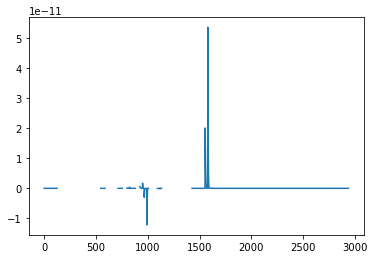

In [12]:
%matplotlib inline
plt.plot(dpred_coarse - dpred_fine)


In [18]:
sl_hm_304 = slice(i_start_hm,i_end_hm)
sl_lm_304 = slice(i_start_lm,i_end_lm)
lm_header_304 = ch1_cols[sl_lm_304]
hm_header_304 = ch2_cols[sl_hm_304]


floor_hm = 0.
floor_lm = 0.
std = 0.05

data = []
uncert = []
for idx in data_lm_all.index:
    if idx%1000==0:
        print(idx)
    data.append(np.r_[data_hm_all.loc[idx+1,hm_header_304].values/area_304,
                      data_lm_all.loc[idx,lm_header_304].values/area_304])
    uncert.append(np.r_[abs(data_hm_all.loc[idx+1,hm_header_304].values)/area_304*std + floor_hm,
                        abs(data_lm_all.loc[idx,lm_header_304].values)/area_304*std + floor_lm])
    
dobs = np.concatenate(data).ravel().astype('float')
uncert = np.concatenate(uncert).ravel().astype('float')
dobs[np.isnan(dobs)] = 9999./area_304
inactive_inds = dobs==9999./area_304
survey.dobs = -dobs.copy() 
uncert[inactive_inds] = np.Inf


DOBS = np.array(data).T
UNCERT  = np.array(uncert).T
invalid_inds = np.logical_or(DOBS==9999./area_304,DOBS==9999.)
DOBS[invalid_inds]=np.nan
DOBS_HM = DOBS[:times_HM_304.size,:]
DOBS_LM = DOBS[times_HM_304.size:,:]


DATA_fine = dpred_fine.reshape((times_HM_304.size+times_LM_304.size, n_sounding), order='F')
DATA_fine[invalid_inds]=np.nan
DATA_HM_fine = -DATA_fine[:times_HM_304.size,:]
DATA_LM_fine = -DATA_fine[times_HM_304.size:,:]

DATA_coarse = dpred_fine.reshape((times_HM_304.size+times_LM_304.size, n_sounding), order='F')
DATA_coarse[invalid_inds]=np.nan
DATA_HM_coarse = -DATA_coarse[:times_HM_304.size,:]
DATA_LM_coarse = -DATA_coarse[times_HM_304.size:,:]

Text(0.5, 1.0, 'Fractional mismatch (simulated-observed)/observed')

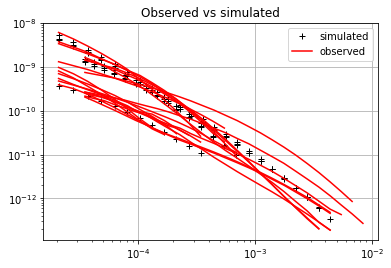

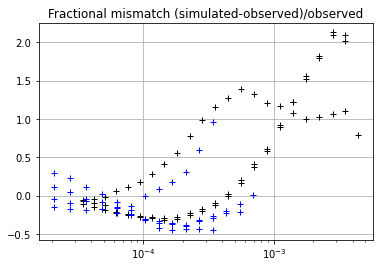

In [14]:
f,ax = plt.subplots(1)

n_lines = 10

l1 = plt.loglog(times_HM_304,DATA_HM[:,:n_lines],'k+',label='simulated')
plt.loglog(times_LM_304,DATA_LM[:,:n_lines],'k+')
l2 = plt.loglog(times_HM_304,DOBS_HM[:,:n_lines],'r',label='observed')
plt.loglog(times_LM_304,DOBS_LM[:,:n_lines],'r')
ax.grid(True)
plt.legend((ax.get_children()[0],ax.get_children()[n_lines*2]),
           (ax.get_children()[0].get_label(),ax.get_children()[n_lines*2].get_label()))
plt.title("Observed vs simulated")


f,ax = plt.subplots(1)
plt.semilogx(times_HM_304,((DATA_HM - DOBS_HM)/DOBS_HM)[:,:n_lines],'k+',label='HM')
plt.semilogx(times_LM_304,((DATA_LM - DOBS_LM)/DOBS_LM)[:,:n_lines],'b+',label='LM')
ax.grid(True)

plt.title('Fractional mismatch (simulated-observed)/observed')

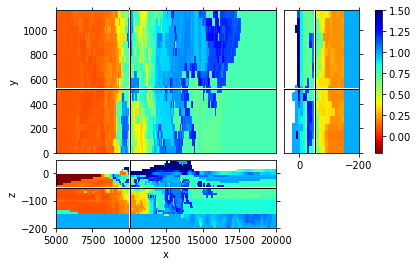

In [24]:
%matplotlib inline

f=plt.figure()
mesh.plot_3d_slicer(np.log10(rho_grid),xslice=10000,yslice=500,zslice=-50,
                    pcolorOpts={'vmin':-.2,'vmax':1.5,'cmap':'jet_r'},
                    fig=f,xlim=(5000,20000),ylim=(0,m_empty.nrow*dy),zlim=(-200,50),)

# ax.set_xlim(5000,15000)
# ax.set_ylim(-150,50)
# mesh.plot_3d_slicer(actv,xslice=10000,yslice=100,zslice=-50)


In [68]:
dpred_fine 

In [69]:
RP_model = varlist['RP_model'][it]
m_ws = varlist['m'][it] #done
CF_cp = varlist['CF_cp'][it] #done
CF_cr = varlist['CF_cr'][it] #done
por = m.btn.prsity.array
lith_180 = np.load(lithdir.joinpath('snesim','mps180_{}.npy'.format(it))).astype(np.float)
lith_400 = np.load(lithdir.joinpath('sisim','sisim400_{}.npy'.format(it))).astype(np.float)


# cf = np.zeros_like(layer_mapping_ind_full,dtype=np.float) #0=Clay, 1=Sand
# cf[np.where(layer_mapping_ind_full==0)] = 1
# cf[np.where(layer_mapping_ind_full==1)] = 1
# cf[np.where(layer_mapping_ind_full==2)] = 0
# cf[np.where(layer_mapping_ind_full==3)] = lith_180[np.where(layer_mapping_ind_full==3)] 
# cf[np.where(layer_mapping_ind_full==4)] = 0
# cf[np.where(layer_mapping_ind_full==5)] = lith_400[np.where(layer_mapping_ind_full==5)] 
# cf[np.where(layer_mapping_ind_full>5)] = 1
# cf[np.where(cf==0)] = CF_cr
# cf[np.where(cf==1)] = CF_cp
# cf = cf[:,rows,:]
# conc[conc > 100.] = np.nan


In [24]:
!ls -lr /scratch/users/ianpg/SWIlarge/work/output/AEM/NM_1_temp/


total 682868
-rw-r--r-- 1 ianpg rknight  9987900 Jul  4 08:16 _inputs_9.pkl
-rw-r--r-- 1 ianpg rknight  9986052 Jul  4 08:16 _inputs_8.pkl
-rw-r--r-- 1 ianpg rknight  9985590 Jul  4 08:16 _inputs_7.pkl
-rw-r--r-- 1 ianpg rknight  9987900 Jul  4 08:16 _inputs_6.pkl
-rw-r--r-- 1 ianpg rknight  9986052 Jul  4 08:16 _inputs_69.pkl
-rw-r--r-- 1 ianpg rknight  9983742 Jul  4 08:16 _inputs_68.pkl
-rw-r--r-- 1 ianpg rknight  9987900 Jul  4 08:16 _inputs_67.pkl
-rw-r--r-- 1 ianpg rknight  9986052 Jul  4 08:16 _inputs_66.pkl
-rw-r--r-- 1 ianpg rknight  9987900 Jul  4 08:16 _inputs_65.pkl
-rw-r--r-- 1 ianpg rknight  9986976 Jul  4 08:16 _inputs_64.pkl
-rw-r--r-- 1 ianpg rknight  9998757 Jul  4 08:16 _inputs_63.pkl
-rw-r--r-- 1 ianpg rknight  9983742 Jul  4 08:16 _inputs_62.pkl
-rw-r--r-- 1 ianpg rknight  9986052 Jul  4 08:16 _inputs_61.pkl
-rw-r--r-- 1 ianpg rknight  9986514 Jul  4 08:16 _inputs_60.pkl
-rw-r--r-- 1 ianpg rknight  9985590 Jul  4 08:16 _inputs_5.pkl
-rw-r--r-- 1 ianpg rknight  9985